In [11]:
# ===========================
# Imports e Configurações
# ===========================
import warnings
warnings.filterwarnings('ignore')

import os, io, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    brier_score_loss
)

In [21]:
#!/usr/bin/env python
import argparse
import pandas as pd

DEFAULT_URL = "https://raw.githubusercontent.com/primaryobjects/voice-gender/master/voice.csv"
DEFAULT_OUT = "voice_local.csv"

def baixar(url: str = DEFAULT_URL, saida: str = DEFAULT_OUT) -> None:
    df = pd.read_csv(url)        # lê direto do link
    df.to_csv(saida, index=False)  # salva localmente
    print(f"OK: '{saida}' salvo com sucesso.")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    print("Colunas:", ", ".join(df.columns))

if __name__ == "__main__":
    # parse_known_args => IGNORA o '-f ...' que o Jupyter passa automaticamente
    parser = argparse.ArgumentParser(description="Baixa um CSV de uma URL e salva localmente.")
    parser.add_argument("url", nargs="?", default=DEFAULT_URL, help="URL do CSV (opcional).")
    parser.add_argument("saida", nargs="?", default=DEFAULT_OUT, help="Nome do arquivo de saída (opcional).")
    args, _unknown = parser.parse_known_args()
    baixar(args.url, args.saida)


OK: 'voice_local.csv' salvo com sucesso.
Dimensões: 3168 linhas x 21 colunas
Colunas: meanfreq, sd, median, Q25, Q75, IQR, skew, kurt, sp.ent, sfm, mode, centroid, meanfun, minfun, maxfun, meandom, mindom, maxdom, dfrange, modindx, label


In [12]:
# ================================================
# Carregamento dos Dados (local -> URL fallback)
# ================================================

URL = "https://raw.githubusercontent.com/primaryobjects/voice-gender/master/voice.csv"
ARQ_LOCAL = "voice.csv"  # Coloque o arquivo na mesma pasta do .ipynb

def carregar_dados(caminho_local=ARQ_LOCAL, url=URL):
    if os.path.exists(caminho_local):
        df = pd.read_csv(caminho_local)
        origem = "local"
    else:
        # Tentativa via URL (só funciona com internet)
        df = pd.read_csv(url)
        origem = "url"
    return df, origem

df, origem = carregar_dados()
print(f"Dados carregados da origem: {origem}. Formato:", df.shape)
display(df.head())

Dados carregados da origem: url. Formato: (3168, 21)


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [13]:
# ============================================================
# Preparação do Alvo (rótulo 'label' -> 0/1) e separação X/y
# ============================================================
if 'label' not in df.columns:
    raise ValueError("Coluna 'label' não encontrada no CSV. Confirme o dataset correto.")

# label: 'male'/'female' -> 0/1 (ex.: female=1, male=0)
df['alvo'] = (df['label'].astype(str).str.lower() == 'female').astype(int)

# Seleção de features numéricas (todas exceto 'label' e 'alvo')
colunas_numericas = [c for c in df.columns if c not in ('label','alvo') and pd.api.types.is_numeric_dtype(df[c])]
X = df[colunas_numericas].copy()
y = df['alvo'].copy()

print("Total de features numéricas:", len(colunas_numericas))
print("Amostras:", X.shape[0])

Total de features numéricas: 20
Amostras: 3168


Proporções de classes (0=male, 1=female):
alvo
0    0.5
1    0.5
Name: proportion, dtype: float64


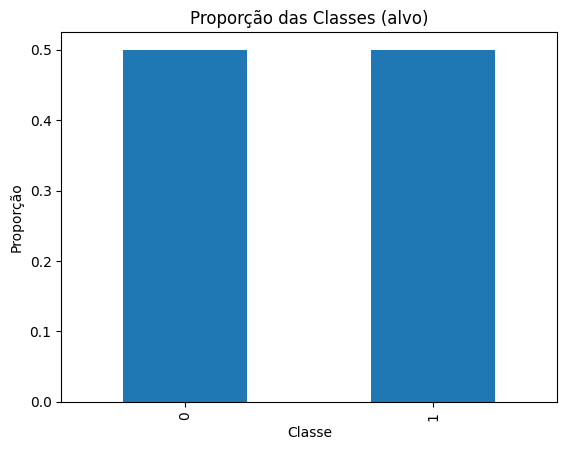

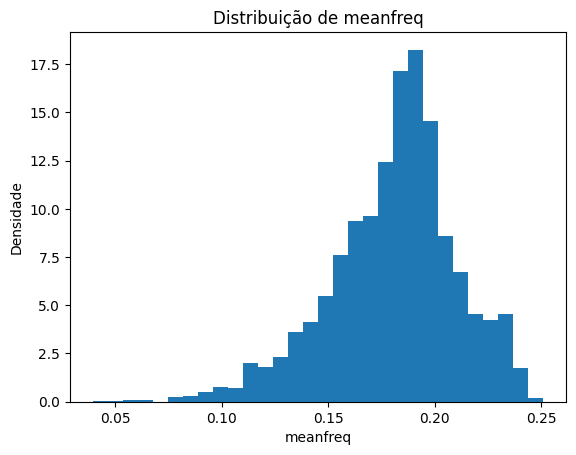

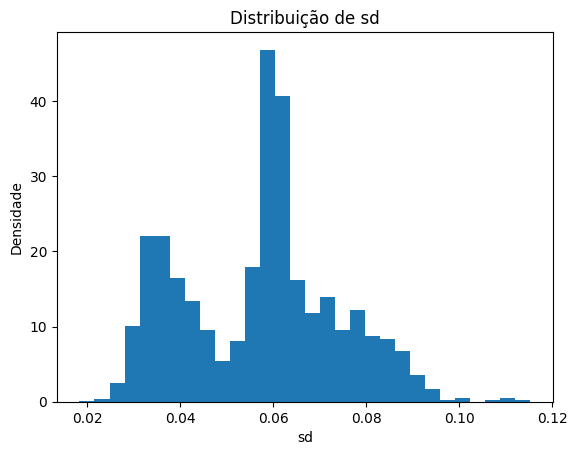

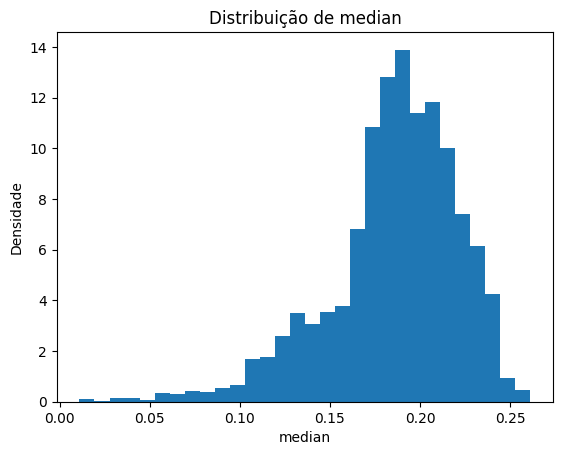

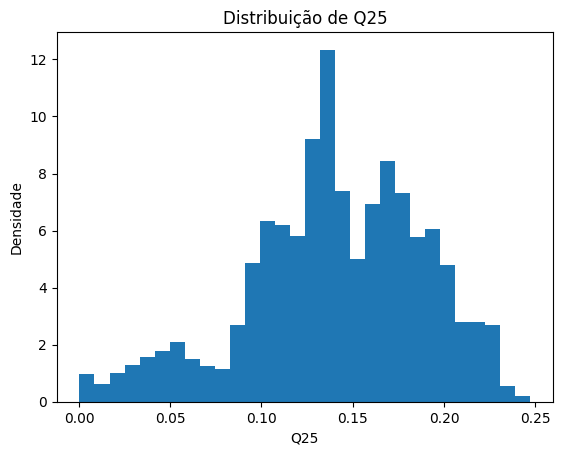

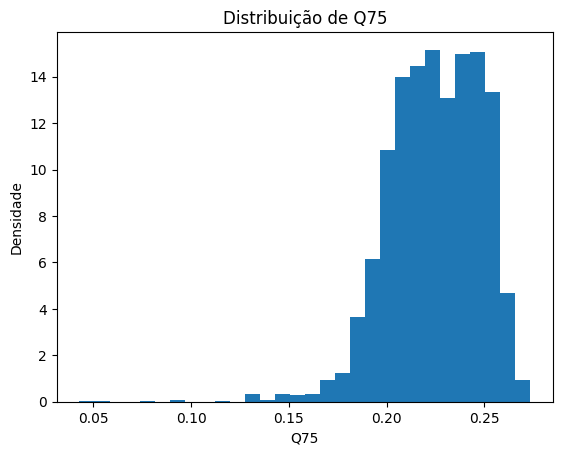

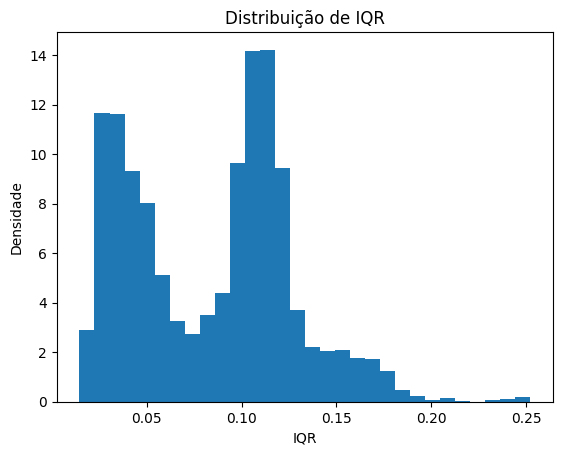

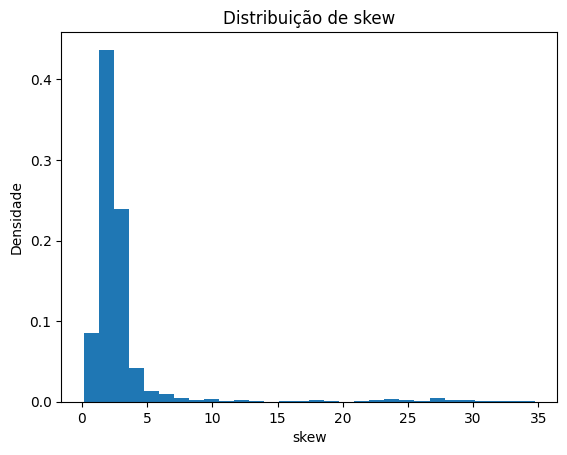

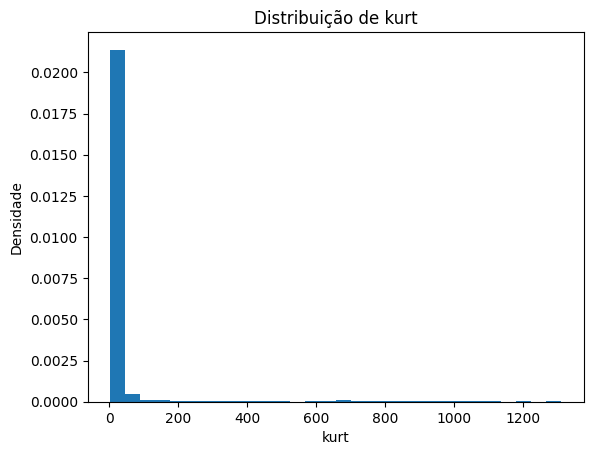

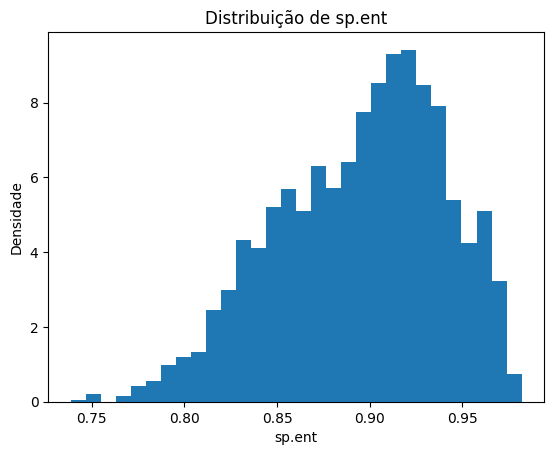

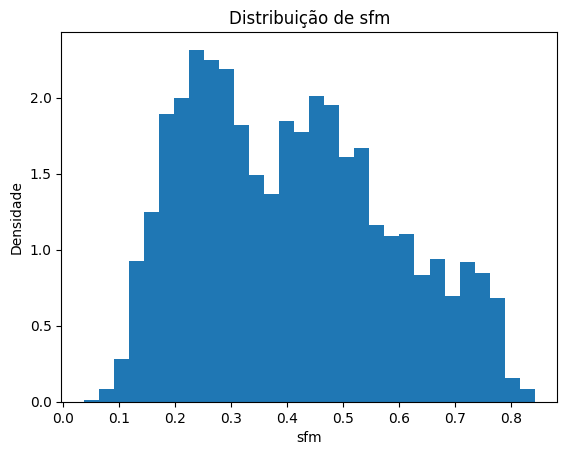

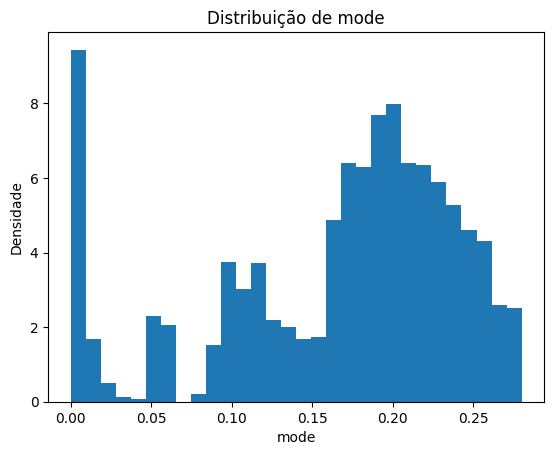

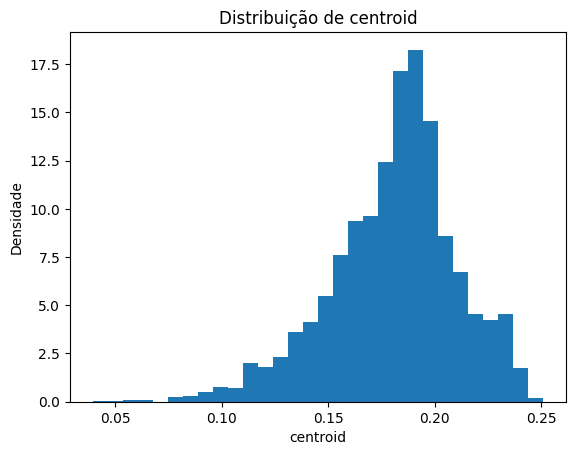

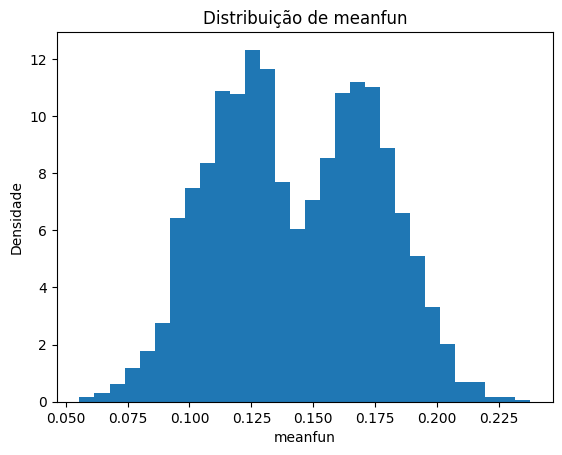

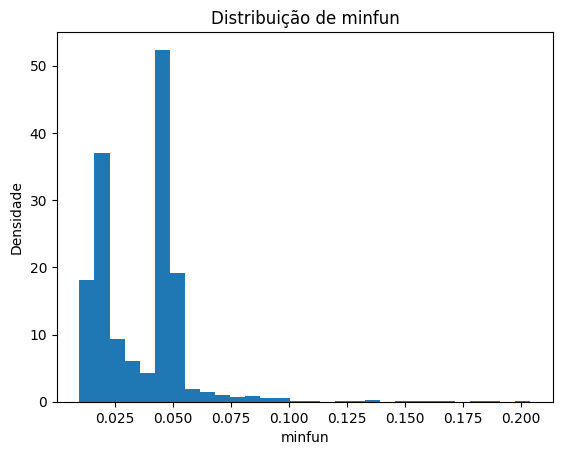

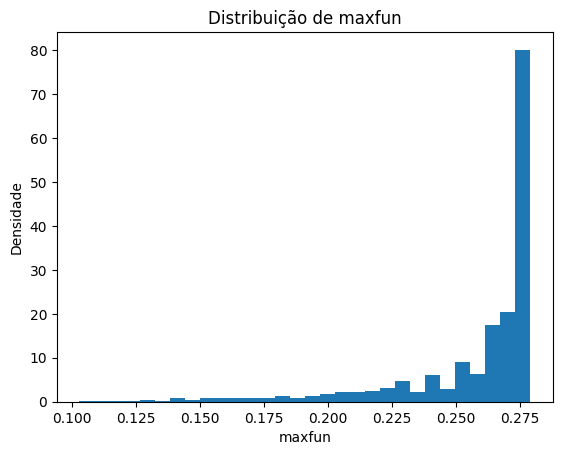

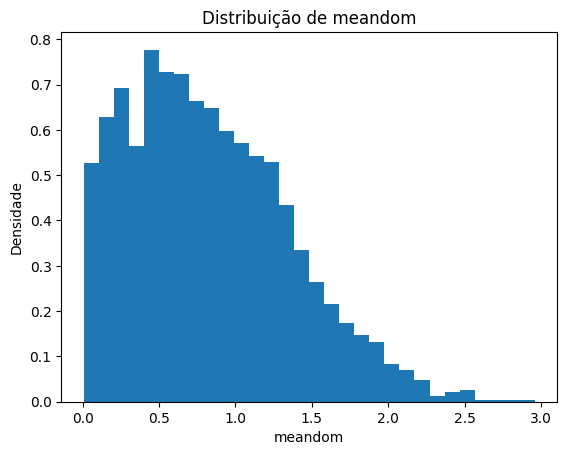

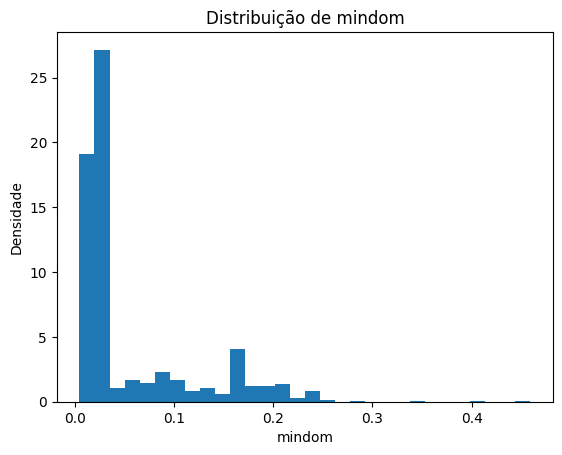

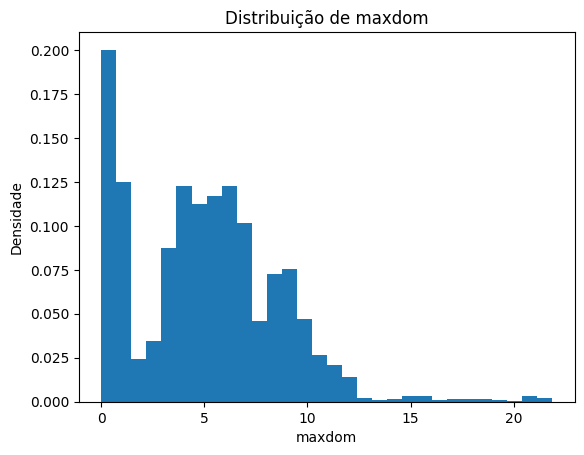

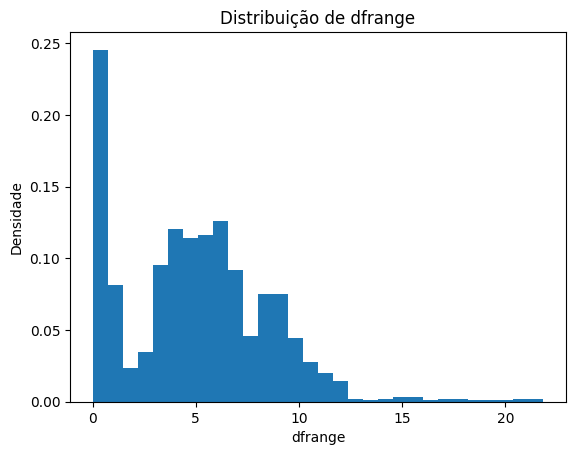

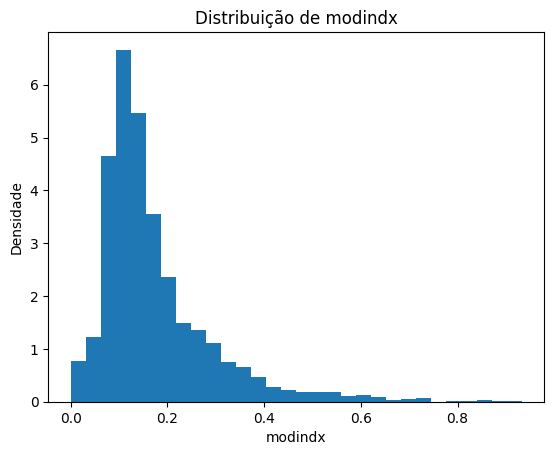

In [14]:
# ===================================
# Parte A.1 — Análise Exploratória
# ===================================

# Proporção de classes (balanceamento)
proporcoes = y.value_counts(normalize=True).sort_index()
print("Proporções de classes (0=male, 1=female):")
print(proporcoes)

# Visualização do balanceamento
fig = plt.figure()
proporcoes.plot(kind='bar')
plt.title("Proporção das Classes (alvo)")
plt.xlabel("Classe")
plt.ylabel("Proporção")
plt.show()

# Distribuições por feature (histogramas com densidade)
for col in colunas_numericas:
    fig = plt.figure()
    plt.hist(X[col], bins=30, density=True)
    plt.title(f"Distribuição de {col}")
    plt.xlabel(col)
    plt.ylabel("Densidade")
    plt.show()

Matriz de correlação - resumo (primeiras 5 linhas):


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
meanfreq,1.000000,-0.739039,0.925445,0.911416,0.740997,-0.627605,-0.322327,-0.316036,-0.601203,-0.784332,0.687715,1.000000,0.460844,0.383937,0.274004,0.536666,0.229261,0.519528,0.515570,-0.216979
sd,-0.739039,1.000000,-0.562603,-0.846931,-0.161076,0.874660,0.314597,0.346241,0.716620,0.838086,-0.529150,-0.739039,-0.466281,-0.345609,-0.129662,-0.482726,-0.357667,-0.482278,-0.475999,0.122660
median,0.925445,-0.562603,1.000000,0.774922,0.731849,-0.477352,-0.257407,-0.243382,-0.502005,-0.661690,0.677433,0.925445,0.414909,0.337602,0.251328,0.455943,0.191169,0.438919,0.435621,-0.213298
Q25,0.911416,-0.846931,0.774922,1.000000,0.477140,-0.874189,-0.319475,-0.350182,-0.648126,-0.766875,0.591277,0.911416,0.545035,0.320994,0.199841,0.467403,0.302255,0.459683,0.454394,-0.141377
Q75,0.740997,-0.161076,0.731849,0.477140,1.000000,0.009636,-0.206339,-0.148881,-0.174905,-0.378198,0.486857,0.740997,0.155091,0.258002,0.285584,0.359181,-0.023750,0.335114,0.335648,-0.216475


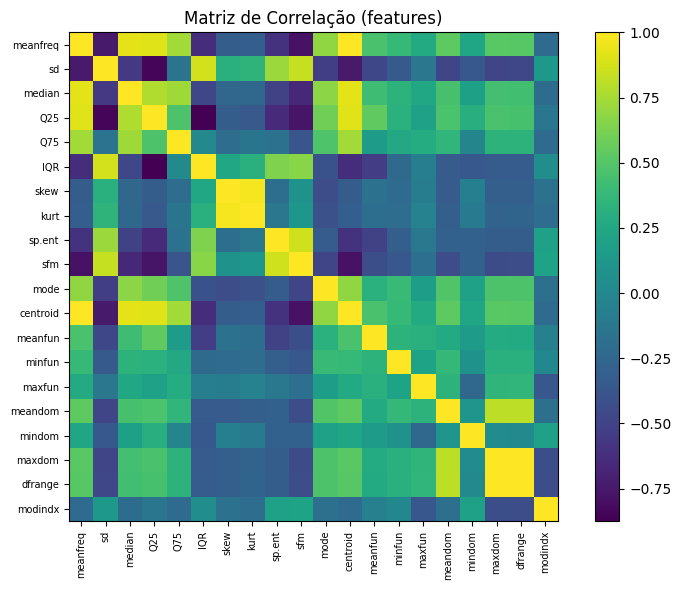

Pares com |correlação| > 0.9: 7
meanfreq x median: r=0.925
meanfreq x Q25: r=0.911
meanfreq x centroid: r=1.000
median x centroid: r=0.925
Q25 x centroid: r=0.911
skew x kurt: r=0.977
maxdom x dfrange: r=1.000
Resumo de escalas por feature (min, max, std):


,min,max,std
kurt,2.068455,1309.612887,134.928661
skew,0.141735,34.725453,4.240529
maxdom,0.007812,21.867188,3.521157
dfrange,0.000000,21.843750,3.520039
meandom,0.007812,2.957682,0.525205
sfm,0.036876,0.842936,0.177521
modindx,0.000000,0.932374,0.119454
mode,0.000000,0.280000,0.077203
mindom,0.004883,0.458984,0.063299
Q25,0.000229,0.247347,0.048680


In [15]:
# Matriz de correlação e verificação simples de multicolinearidade
corr = X.corr(numeric_only=True)
print("Matriz de correlação - resumo (primeiras 5 linhas):")
display(corr.head())

# Heatmap com matplotlib (sem seaborn)
fig = plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.title("Matriz de Correlação (features)")
plt.colorbar()
plt.xticks(range(len(colunas_numericas)), colunas_numericas, rotation=90, fontsize=7)
plt.yticks(range(len(colunas_numericas)), colunas_numericas, fontsize=7)
plt.tight_layout()
plt.show()

# Pares altamente correlacionados (|r| > 0.9) para discussão de multicolinearidade
pares_alta_corr = []
thr = 0.9
for i in range(len(colunas_numericas)):
    for j in range(i+1, len(colunas_numericas)):
        r = corr.iloc[i,j]
        if abs(r) > thr:
            pares_alta_corr.append((colunas_numericas[i], colunas_numericas[j], r))

print(f"Pares com |correlação| > {thr}: {len(pares_alta_corr)}")
for a,b,r in pares_alta_corr[:10]:  # mostra alguns se houver muitos
    print(f"{a} x {b}: r={r:.3f}")

# Escalas: checagem de faixa (min, max, std) por feature para justificar padronização
stats = pd.DataFrame({
    "min": X.min(),
    "max": X.max(),
    "std": X.std()
}).sort_values("std", ascending=False)
print("Resumo de escalas por feature (min, max, std):")
display(stats)

In [16]:
# =============================================
# Split e Padronização (StandardScaler) – Parte A
# =============================================
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_treino_std = scaler.fit_transform(X_treino)
X_teste_std  = scaler.transform(X_teste)

print("Formatos:", X_treino_std.shape, X_teste_std.shape)

Formatos: (2534, 20) (634, 20)


In [17]:
# ================================================
# Parte A.2 — GridSearchCV (L1 vs L2, C variados)
# ================================================
param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.01, 0.1, 1.0, 10.0, 100.0],
    "solver": ["liblinear"],  # suporta l1 e l2 para binário
    "max_iter": [1000]
}

base_model = LogisticRegression()
cv = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    return_train_score=True
)
cv.fit(X_treino_std, y_treino)

print("Melhores parâmetros:", cv.best_params_)
print("Acurácia média de validação (CV):", f"{cv.best_score_:.4f}")

# Resultados completos do Grid
res = pd.DataFrame(cv.cv_results_).sort_values("mean_test_score", ascending=False)
display(res[["param_penalty","param_C","mean_test_score","std_test_score","mean_train_score"]].head(10))

Melhores parâmetros: {'C': 10.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Acurácia média de validação (CV): 0.9767


,param_penalty,param_C,mean_test_score,std_test_score,mean_train_score
7,l2,10.00,0.976712,0.008518,0.977703
8,l1,100.00,0.976317,0.008200,0.977604
9,l2,100.00,0.976317,0.008200,0.977604
6,l1,10.00,0.975923,0.007650,0.977604
4,l1,1.00,0.975528,0.008166,0.977703
5,l2,1.00,0.975133,0.007774,0.976815
2,l1,0.10,0.973161,0.006810,0.974743
3,l2,0.10,0.971975,0.009059,0.973954
0,l1,0.01,0.964872,0.010268,0.964877
1,l2,0.01,0.963686,0.010956,0.964877


Acurácia: 0.9621
Precisão: 0.9651
Recall:   0.9590
F1-score: 0.9620

Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.9592    0.9653    0.9623       317
           1     0.9651    0.9590    0.9620       317

    accuracy                         0.9621       634
   macro avg     0.9622    0.9621    0.9621       634
weighted avg     0.9622    0.9621    0.9621       634



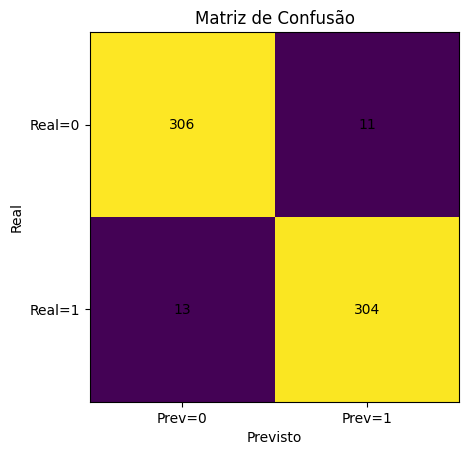

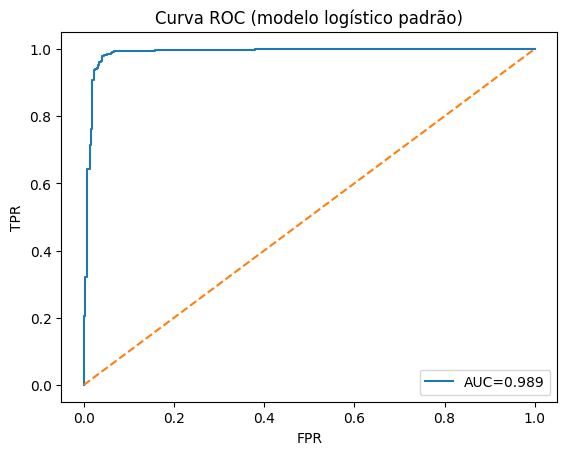

In [18]:
# ==============================
# Parte A.3 — Modelo Final
# ==============================
best_lr = cv.best_estimator_
best_lr.fit(X_treino_std, y_treino)

y_pred = best_lr.predict(X_teste_std)
y_proba = best_lr.predict_proba(X_teste_std)[:,1]

acc  = accuracy_score(y_teste, y_pred)
prec = precision_score(y_teste, y_pred)
rec  = recall_score(y_teste, y_pred)
f1   = f1_score(y_teste, y_pred)

print(f"Acurácia: {acc:.4f}")
print(f"Precisão: {prec:.4f}")
print(f"Recall:   {rec:.4f}")
print(f"F1-score: {f1:.4f}\n")

print("Relatório de Classificação:")
print(classification_report(y_teste, y_pred, digits=4))

# Matriz de confusão
cm = confusion_matrix(y_teste, y_pred)
fig = plt.figure()
plt.imshow(cm, cmap=None)
plt.title("Matriz de Confusão")
plt.xticks([0,1], ["Prev=0","Prev=1"])
plt.yticks([0,1], ["Real=0","Real=1"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

# ROC
fpr, tpr, thr = roc_curve(y_teste, y_proba)
roc_auc = auc(fpr, tpr)

fig = plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC (modelo logístico padrão)")
plt.legend()
plt.show()

Melhor L1: C=100.0 (CV=0.9763) | Melhor L2: C=10.0 (CV=0.9767)


,feature,coef_L1,coef_L2
12,meanfun,5.764898,5.682555
9,sfm,2.175116,2.073705
8,sp.ent,-1.941423,-1.832246
5,IQR,-1.938414,-1.765976
11,centroid,-1.610189,-1.181830
3,Q25,1.502476,1.589438
0,meanfreq,-0.974266,-1.181830
2,median,0.928197,0.860589
13,minfun,-0.712064,-0.696978
7,kurt,0.634656,0.581781


Variáveis com coeficiente 0 (L1): 0
[]


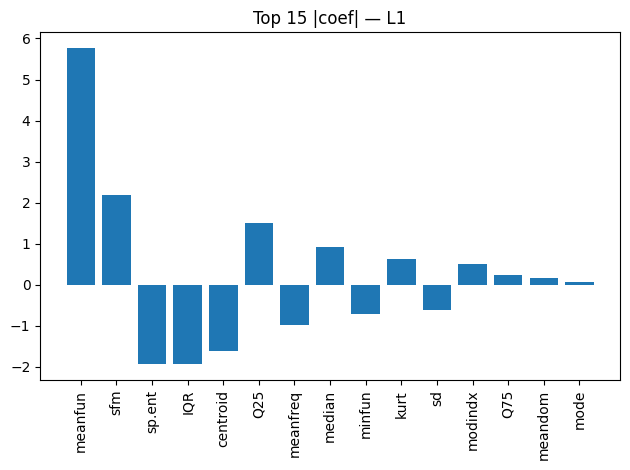

In [19]:
# ==========================================================
# Parte A.4 — Coeficientes: L1 (Lasso) vs L2 (Ridge) 
# e variáveis "eliminadas" (coef == 0 no L1)
# ==========================================================

# Identificar o melhor C separadamente por penalty usando os resultados do grid
res = pd.DataFrame(cv.cv_results_)

def melhor_por_penalty(res, penalty):
    r = res[res["param_penalty"] == penalty]
    # Escolhe a linha com maior mean_test_score; em caso de empate, menor C
    r = r.sort_values(["mean_test_score","param_C"], ascending=[False, True]).iloc[0]
    return float(r["param_C"]), float(r["mean_test_score"])

C_l1, score_l1 = melhor_por_penalty(res, "l1")
C_l2, score_l2 = melhor_por_penalty(res, "l2")
print(f"Melhor L1: C={C_l1} (CV={score_l1:.4f}) | Melhor L2: C={C_l2} (CV={score_l2:.4f})")

lr_l1 = LogisticRegression(penalty="l1", C=C_l1, solver="liblinear", max_iter=1000).fit(X_treino_std, y_treino)
lr_l2 = LogisticRegression(penalty="l2", C=C_l2, solver="liblinear", max_iter=1000).fit(X_treino_std, y_treino)

coef_l1 = lr_l1.coef_.ravel()
coef_l2 = lr_l2.coef_.ravel()

# Mapeia coeficientes para nomes de features
coef_df = pd.DataFrame({
    "feature": colunas_numericas,
    "coef_L1": coef_l1,
    "coef_L2": coef_l2
}).sort_values("coef_L1", key=lambda s: np.abs(s), ascending=False)

display(coef_df.head(15))

# Variáveis eliminadas (coeficientes exatamente 0 no L1 com liblinear)
eliminadas = [f for f,c in zip(colunas_numericas, coef_l1) if c == 0.0]
print(f"Variáveis com coeficiente 0 (L1): {len(eliminadas)}")
print(eliminadas)

# Visual: barras dos 15 maiores |coef| no L1
top = coef_df.head(15)
fig = plt.figure()
plt.bar(range(len(top)), top["coef_L1"])
plt.xticks(range(len(top)), top["feature"], rotation=90)
plt.title("Top 15 |coef| — L1")
plt.tight_layout()
plt.show()

## Parte B — Alterando a Função de Perda (RMSE)
A regressão logística tradicional minimiza **log-loss** (entropia cruzada).  
Aqui, implementamos um **modelo alternativo** que aprende **pesos (w,b)** usando **gradiente descendente** para **minimizar MSE** entre `y` e `sigmoid(Xw+b)`. 
> Observação: minimizar **RMSE** ou **MSE** leva ao **mesmo minimizador**, pois RMSE é apenas a raiz de MSE (função monótona). Reportamos **RMSE** para comparação, mas otimizamos MSE por simplicidade analítica.

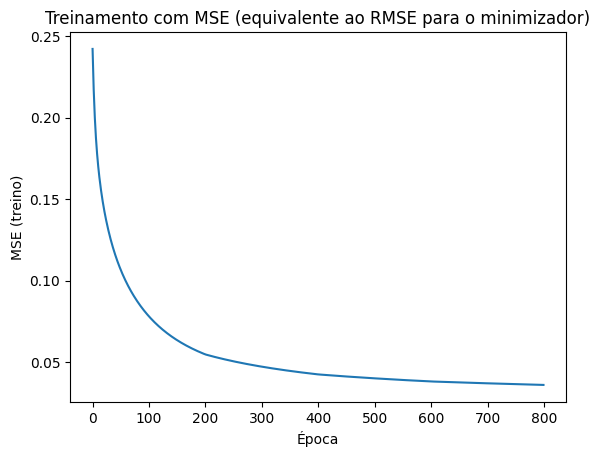

[RMSE-model] Acurácia: 0.9590
[RMSE-model] Precisão: 0.9678
[RMSE-model] Recall:   0.9495
[RMSE-model] F1-score: 0.9586
[RMSE-model] RMSE (teste): 0.2017


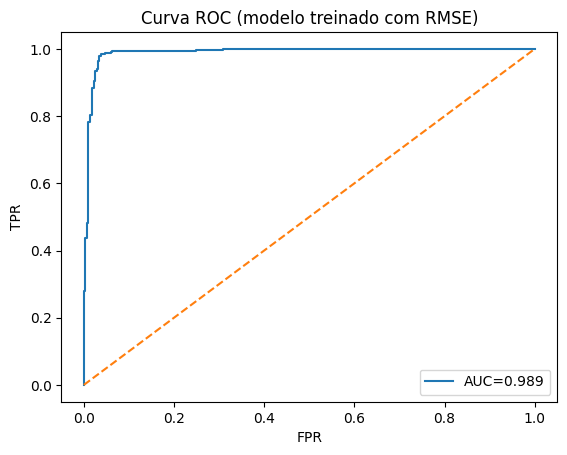

Brier score - Logístico padrão: 0.0287
Brier score - Modelo RMSE:     0.0407


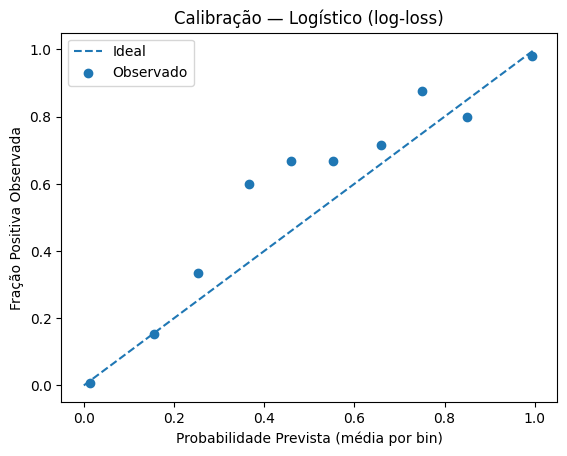

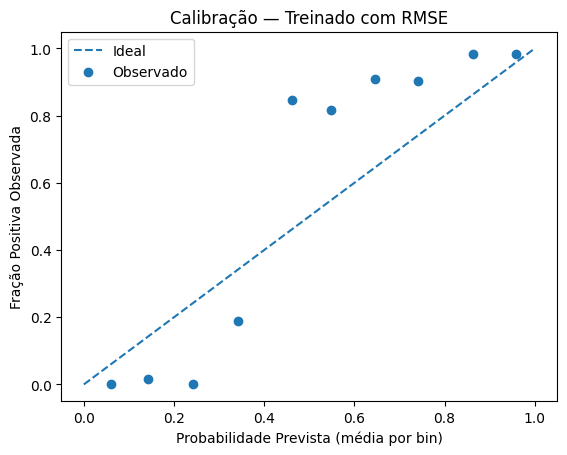

In [20]:
# =========================================
# Implementação "do-zero" com RMSE (MSE)
# =========================================

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def mse(y_true, y_prob):
    # y_true ∈ {0,1}, y_prob ∈ (0,1)
    return np.mean((y_true - y_prob)**2)

def treinar_rmse_logistico(X_std, y, lr=0.1, epochs=800, seed=42):
    rng = np.random.default_rng(seed)
    n, d = X_std.shape
    w = rng.normal(scale=0.01, size=d)
    b = 0.0
    
    historico = []
    for ep in range(1, epochs+1):
        z = X_std @ w + b
        p = sigmoid(z)
        # perda MSE
        loss = mse(y, p)
        historico.append(loss)
        
        # gradientes (MSE): d/dw = (2/n) * X^T * (p - y) * p*(1-p)
        # corrente de erro: (p - y) * p*(1-p)
        erro = (p - y) * p * (1 - p)
        grad_w = (2.0 / n) * (X_std.T @ erro)
        grad_b = (2.0 / n) * np.sum(erro)
        
        w -= lr * grad_w
        b -= lr * grad_b
        
        # opcional: leve decaimento de taxa de aprendizado
        if ep % 200 == 0:
            lr *= 0.7
    return w, b, np.array(historico)

w_rmse, b_rmse, hist = treinar_rmse_logistico(X_treino_std, y_treino.values.astype(float))

# Curva de treinamento (MSE)
fig = plt.figure()
plt.plot(hist)
plt.xlabel("Época")
plt.ylabel("MSE (treino)")
plt.title("Treinamento com MSE (equivalente ao RMSE para o minimizador)")
plt.show()

# Avaliação no teste
p_teste = sigmoid(X_teste_std @ w_rmse + b_rmse)
y_pred_rmse = (p_teste >= 0.5).astype(int)

acc_rmse  = accuracy_score(y_teste, y_pred_rmse)
prec_rmse = precision_score(y_teste, y_pred_rmse)
rec_rmse  = recall_score(y_teste, y_pred_rmse)
f1_rmse   = f1_score(y_teste, y_pred_rmse)
rmse_val  = math.sqrt(mse(y_teste.values.astype(float), p_teste))

print(f"[RMSE-model] Acurácia: {acc_rmse:.4f}")
print(f"[RMSE-model] Precisão: {prec_rmse:.4f}")
print(f"[RMSE-model] Recall:   {rec_rmse:.4f}")
print(f"[RMSE-model] F1-score: {f1_rmse:.4f}")
print(f"[RMSE-model] RMSE (teste): {rmse_val:.4f}")

# ROC do modelo RMSE
fpr2, tpr2, thr2 = roc_curve(y_teste, p_teste)
roc_auc2 = auc(fpr2, tpr2)

fig = plt.figure()
plt.plot(fpr2, tpr2, label=f"AUC={roc_auc2:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC (modelo treinado com RMSE)")
plt.legend()
plt.show()

# "Curva de decisão" -> aqui usamos um gráfico de calibração (reliability diagram)
# para verificar se as probabilidades estão calibradas.
def grafico_calibracao(y_true, y_prob, n_bins=10, titulo="Calibração"):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    xs, ys = [], []
    for i in range(n_bins):
        mask = (y_prob >= bins[i]) & (y_prob < bins[i+1])
        if mask.sum() > 0:
            xs.append(y_prob[mask].mean())
            ys.append(y_true[mask].mean())
    fig = plt.figure()
    plt.plot([0,1],[0,1], linestyle='--', label="Ideal")
    if xs:
        plt.scatter(xs, ys, label="Observado")
    plt.xlabel("Probabilidade Prevista (média por bin)")
    plt.ylabel("Fração Positiva Observada")
    plt.title(titulo)
    plt.legend()
    plt.show()

# Calibração: modelo padrão vs modelo RMSE
brier_std  = brier_score_loss(y_teste, y_proba)
brier_rmse = brier_score_loss(y_teste, p_teste)
print(f"Brier score - Logístico padrão: {brier_std:.4f}")
print(f"Brier score - Modelo RMSE:     {brier_rmse:.4f}")

grafico_calibracao(y_teste, y_proba, titulo="Calibração — Logístico (log-loss)")
grafico_calibracao(y_teste, p_teste,  titulo="Calibração — Treinado com RMSE")